In [4]:
#Diffusion Sigma analysis
#Get final R position of a drift line (no diffusion)
#   - Compare to 100 diffusion lines (Use a blue histogram and a black x)
#   - Fit a gaussian to the histogram - extract mu and sigma
#   - Compare Gaussian to mu and sigma to final drift position and sqrt(4*D_T*DriftTime)
#   - Repeat for 9 positions (0,2) --> (72.5, 2)

In [26]:

#INITIALIZION
#Kernel PyROOT
import os
#os.sys.path.append('/usr/common/software/rootpy')
#os.sys.path.insert(0,'/usr/common/software/uproot')
#import root_numpy
#import root_numpy as root_np
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use('GTK3Agg')
import ROOT
import pandas as pd

import sys
from matplotlib.colors import LogNorm
import pylab

import glob
import uproot

import scipy
from scipy.optimize import curve_fit
from scipy.stats import norm

%pylab inline
#pylab.rcParams['figure.figsize'] = (10.0, 8.0)

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

print("Starting notebook....")

#Function to get directory list
def Get_folders_in_dir(d):
    [os.path.join(d, o) for o in os.listdir(d) 
                        if os.path.isdir(os.path.join(d,o))]
    return os.listdir(d)

#For individual subdir get all files
def Get_All_files(d):
    file_list=[]
    for file in os.listdir(d):
        if file.endswith(".txt"):
            #print(os.path.join(file))
            file_list.append(d+os.path.join(file))
    return file_list

#Get the i^th entry from a file
def Get_i_line_from_file(filename, i):
    file = open(filename, 'r')
    lines = file.readlines()
    a = lines[i].split('\t\t')
    DriftTime_us= float(a[2])
    r_cm = float(a[3])
    z_cm = float(a[4])
    return r_cm, z_cm, DriftTime_us


#Get list of final R and driftline positions
def Get_list_of_final_R_DT(file_list):
    r_list = []
    DT_list = []
    for i in range(0,len(file_list)):
        j=-1
        r,z,t= Get_i_line_from_file(file_list[i],j)
        r_list.append(r)
        DT_list.append(t)
        #CHECK to make sure drift time makes sense
        if t > 800:
            print str(r)+"\t"+str(z)+"\t"+str(t)
    return r_list, DT_list


def Gaussian(x, mu, sigma):
    A= 1/(sigma*pow(2*pi,.5))
    B= -.5*pow((x-mu)/sigma, 2.)
    return A*np.exp(B)
vGaussian = np.vectorize(Gaussian)

#Function to turn file into arrays
def Get_drift_line_arrays(filename):
    file = open(filename, 'r')
    lines = file.readlines()

    #print len(lines)
    #print lines[2]

    rIN_cm = float(lines[10].split('\t\t')[0])
    zIN_cm = float(lines[10].split('\t\t')[1])

    DriftTime_us_list = []
    r_cm_list = []
    z_cm_list = []

    DriftTime_us_list.append(0.0)
    r_cm_list.append(rIN_cm)
    z_cm_list.append(zIN_cm)

    for i in range(0,len(lines)):
        if lines[i].startswith('#'):
            continue
        elif lines[i].startswith('*'):
            print lines[i]
        elif lines[i].startswith('0') or lines[i].startswith('1') or lines[i].startswith('2')\
        or lines[i].startswith('3') or lines[i].startswith('4') or lines[i].startswith('5')\
        or lines[i].startswith('6') or lines[i].startswith('7') or lines[i].startswith('8')\
        or lines[i].startswith('9'):
            a = lines[i].split('\t\t')
            #print a
            DriftTime_us_list.append(float(a[2]))
            r_cm_list.append(float(a[3]))
            z_cm_list.append(float(a[4]))
        else:
            continue
    return np.asarray(r_cm_list), np.asarray(z_cm_list), np.asarray(DriftTime_us_list)



def Get_file_length(filename):
    file = open(filename, 'r')
    lines = file.readlines()
    return len(lines)




from scipy.stats import norm

def Get_Zeroed_R_list(filename, data_dir):
    print data_dir
    file_list=[]
    for file in os.listdir(data_dir):
        if file.endswith(".txt"):
            print(os.path.join(file))
            file_list.append(data_dir+os.path.join(file))
           
    r_list = []
    z_list = []
    t_list = []
    j=-1
    #print j
    for f in file_list[:-1]:
        r,z,t= Get_i_line_from_file(f,j)
        r_list.append(r)
        z_list.append(z)
        t_list.append(t)
    r,z,t=Get_i_line_from_file(filename,pop)
    print "\t"+str(filename)
    zeroed_r_array = np.asarray(r_list)-r
    
    fit_mu, fit_sigma = norm.fit(zeroed_r_array)
    
    #Inspect initial histogram
    num_bins =  10
    #(full_n, full_bins, full_patches) = plt.hist(Full_Reduced_R_list, bins=num_bins)
    figure(1)
    (n_R, bins, patches) = plt.hist(zeroed_r_array, bins=num_bins)

    #Get bin mids
    print bins.shape
    print bins

    R_bin_mids_list = []
    for i in range(1, len(bins)):
        R_bin_mids_list.append( (bins[i] + bins[i-1])/2 )

    this_half_bid_width = .5*(R_bin_mids_list[1] - R_bin_mids_list[0])

    #print bin_mids_list[-1]
    #print bin_mids_list[-1]+this_half_bid_width
    #print bin_mids_list[-1]-this_half_bid_width


    #Remove bins with n<threshold, & remove top bin
    threshold=0


    counter = 0
    new_bin_mids_list = []
    new_n_list = []
    for i in range(0, len(n_R)):
        if n_R[i] < threshold:# or n_R[i] > 15000:
            #print( str(i)+": ("+str(bin_mids_list[i])+", "+str(n[i])+")" )
            counter +=1
        else:
            new_bin_mids_list.append(R_bin_mids_list[i])
            new_n_list.append(n_R[i])

    #Inspect elements with n>10
    #figure(2)
    #plt.plot(R_bin_mids_list, n_R, ".")
    #plt.plot(new_bin_mids_list,  new_n_list, 'x')
    
    return zeroed_r_array, fit_mu, fit_sigma, new_bin_mids_list, new_n_list
    


print "\n\t...Done!"

Populating the interactive namespace from numpy and matplotlib
Starting notebook....

	...Done!


In [27]:
#Constants
D_T = 55e-6 #cm^2/us

print "\n\t...Done!"


	...Done!


In [114]:
#Get list of directorys for diffusion lines
d_1 = "/data/rossiter/lz/EDM_DiffusionAnalysis_2005/"
d_2 = "/data/rossiter/lz/EDM_DiffusionAnalysis_2005_2/"
d_3 = "/home/rossiter/LZ_EDM_200501/DiffusionAnalysis_0505/"
dir_list = []

temp_dir_list = Get_folders_in_dir(d_2)

for d in temp_dir_list:
    if d.startswith('r'):
        #print d
        dir_list.append(d_2+d+'/')

temp_dir_list = Get_folders_in_dir(d_1)
for d in temp_dir_list:
    if d=='r0' or d =='r70':
        #print d
        dir_list.append(d_1+d+'/')

print dir_list[0]

print "\n\t...Done!"

/data/rossiter/lz/EDM_DiffusionAnalysis_2005_2/r43.75/

	...Done!


In [115]:
for ii in range(0,len(dir_list)):
    r_origin = dir_list[ii].split("/")[-2].split("r")[1]
    print r_origin

43.75
35
26.25
52.5
61.25
17.5
08.75
0
70


In [116]:

ii=8
#Get original r position of sim
r_origin = dir_list[ii].split("/")[-2].split("r")[1]
print "r_origin = "+str(r_origin)
#For individual subdir get all files
file_list = Get_All_files(dir_list[ii])
print file_list[0]
#For one diffusion line get last entry which makes sense        
r_list, DT_list = Get_list_of_final_R_DT(file_list)
print "len(r_list) = "+str(len(r_list))
print "len(DT_list) = "+str(len(DT_list))

print "\n\t...Done!"



r_origin = 70
/data/rossiter/lz/EDM_DiffusionAnalysis_2005/r70/SingleDiffusionLineMC_TimeStep_.32us_r70._100.txt
len(r_list) = 100
len(DT_list) = 100

	...Done!


In [125]:
#Condense r_list, and, DT_list into a single file
d_4 = "/data/rossiter/lz/EDM_DiffusionAnalysis_2005_2/Condensed/"
output_filename = d_4+"r"+r_origin+'.txt'
print output_filename

f=open(output_filename, "w")
f.write("#r_cm\tDT_us\n")
for i in range(0, len(r_list)):
    f.write(str(r_list[i])+"\t"+str(DT_list[i])+"\n")

f.close

print "\n\t ...r"+r_origin+'.txt written!'

/data/rossiter/lz/EDM_DiffusionAnalysis_2005_2/Condensed/r70.txt

	 ...r70.txt written!


In [117]:
#For a single diffusion analysis get a histogram of final positions
filename = d_3+"SingleDriftLineCalc_.5cm_r"+str(70)+"cm_z02.0cm_0504.txt"
drift_r,drift_z,drift_t=Get_i_line_from_file(filename,-1)

print "Driftline: r = "+str(r)+"\t z = "+str(z)+"\t t = "+str(t)


print "\n\t...Done!"

Driftline: r = 69.8755	 z = 146.1	 t = 789.969

	...Done!


In [118]:
#Get Gaussian fit for hist and a predicted Gaussian from the line without diffusion

fit_mu, fit_sigma = norm.fit(r_list)

GausFit_x = np.arange(min(h_center-fit_sigma), max(h_center+fit_sigma), .01)
GausFit_y = vGaussian(GausFit_x, fit_mu, fit_sigma)

n=3.
GausPred_x = np.arange(drift_r - n*pow(4*D_T*drift_t,.5), drift_r + n*pow(4*D_T*drift_t,.5), .01)
GausPred_y = vGaussian(GausPred_x, drift_r, pow(4*D_T*drift_t,.5))


print "\n\t...Gaussian fit generated!"


	...Gaussian fit generated!


(array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14]),
 <a list of 8 Text yticklabel objects>)

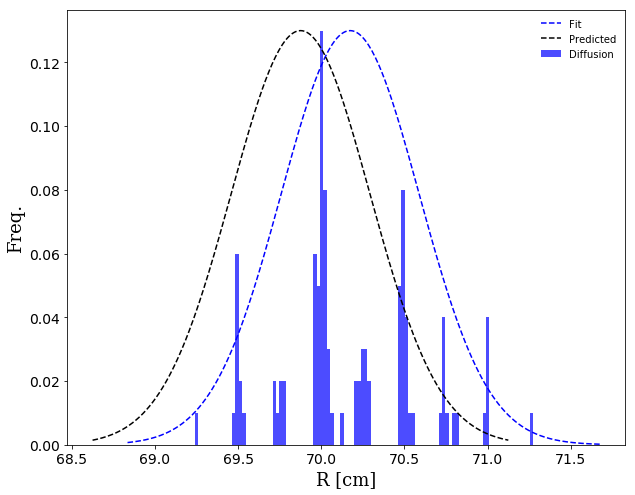

In [119]:
#Make histogram
hist, n_bins = np.histogram(r_list, bins=100)
h_center = (n_bins[:-1] + n_bins[1:]) / 2
hist = hist.astype(np.float) / sum(hist.astype(np.float))

#Normalise Gaussian fits
GausFitNorm = max(hist)/max(GausFit_y)
GausPredNorm= max(hist)/max(GausPred_y)

w = (n_bins[1] - n_bins[0]) #*.7


plt.bar(h_center, hist, align='center', color='blue', alpha=.7, width=w, label='Diffusion')
#plt.plot(drift_r, max(hist), marker="x", color='k', markersize=22, label='Drift line')

plt.plot(GausFit_x, GausFit_y*GausFitNorm, '--b', label="Fit")
plt.plot(GausPred_x, GausPred_y*GausPredNorm, '--k', label="Predicted")

plt.xlabel('R [cm]',fontsize=18,family='serif');
plt.ylabel('Freq.',fontsize=18,family='serif');
plt.legend(frameon=False, loc='best');
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)



SingleDriftLineCalc_.5cm_r30cm_z01cm_0504.txt
./r0/
SingleDiffusionLineMC_TimeStep_.32us_r00_28.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_1.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_30.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_2.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_29.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_3.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_31.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_4.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_32.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_5.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_33.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_6.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_34.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_7.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_35.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_8.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_36.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_9.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_37.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_10.t

	SingleDriftLineCalc_.5cm_r10cm_z01cm_0504.txt
(11,)
[0.00809208 0.08280057 0.15750906 0.23221756 0.30692605 0.38163454
 0.45634303 0.53105152 0.60576002 0.68046851 0.755177  ]
SingleDriftLineCalc_.5cm_r20cm_z01cm_0504.txt
./r0/
SingleDiffusionLineMC_TimeStep_.32us_r00_28.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_1.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_30.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_2.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_29.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_3.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_31.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_4.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_32.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_5.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_33.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_6.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_34.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_7.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_35.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_8.txt
SingleDiffu

	SingleDriftLineCalc_.5cm_r50cm_z01cm_0504.txt
(11,)
[0.00809208 0.08280057 0.15750906 0.23221756 0.30692605 0.38163454
 0.45634303 0.53105152 0.60576002 0.68046851 0.755177  ]
SingleDriftLineCalc_.5cm_r70cm_z01cm_0504.txt
./r0/
SingleDiffusionLineMC_TimeStep_.32us_r00_28.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_1.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_30.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_2.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_29.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_3.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_31.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_4.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_32.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_5.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_33.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_6.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_34.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_7.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_35.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_8.txt
SingleDiffu

	SingleDriftLineCalc_.5cm_r00cm_z01cm_0504.txt
(11,)
[0.00809208 0.08280057 0.15750906 0.23221756 0.30692605 0.38163454
 0.45634303 0.53105152 0.60576002 0.68046851 0.755177  ]
SingleDriftLineCalc_.5cm_r40cm_z01cm_0504.txt
./r0/
SingleDiffusionLineMC_TimeStep_.32us_r00_28.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_1.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_30.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_2.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_29.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_3.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_31.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_4.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_32.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_5.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_33.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_6.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_34.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_7.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_35.txt
SingleDiffusionLineMC_TimeStep_.32us_r00_8.txt
SingleDiffu

	SingleDriftLineCalc_.5cm_r60cm_z01cm_0504.txt
(11,)
[0.00809208 0.08280057 0.15750906 0.23221756 0.30692605 0.38163454
 0.45634303 0.53105152 0.60576002 0.68046851 0.755177  ]


len(r_origin_list): 8
len(z_origin_list): 8
len(ALL_zeroed_r_arrays): 8
len(fit_mu_list): 8
len(fit_sigma_list): 8
len(bin_mids_lol)8
len(n_lol)8

	..Done!


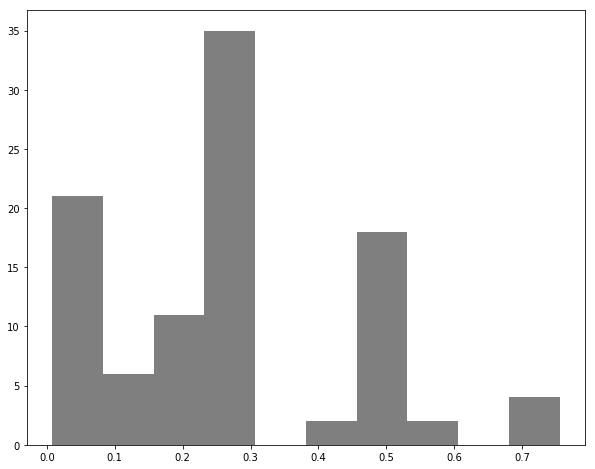

In [71]:
"""#
r_origin_list =[]
z_origin_list =[]
ALL_zeroed_r_arrays = []
fit_mu_list = []
fit_sigma_list = []
bin_mids_lol= []
n_lol = []

for i in range(0,len(dir_list)):
    r_temp= dir_list[i].split('r')[1]
    if float(r_temp) < 10:
        filename="SingleDriftLineCalc_.5cm_r0"+str(r_temp)+"cm_z01cm_0504.txt"
    else:
        filename="SingleDriftLineCalc_.5cm_r"+str(r_temp)+"cm_z01cm_0504.txt"
    print filename
    pop=-2
    zeroed_r_array, fit_mu, fit_sigma, new_bin_mids_list, new_n_list = Get_Zeroed_R_list(filename, data_dir)
    
    r_origin_list.append(r_temp)
    z_origin_list.append("01")
    ALL_zeroed_r_arrays.append(zeroed_r_array)
    fit_mu_list.append(fit_mu)
    fit_sigma_list.append(fit_sigma)
    bin_mids_lol.append(new_bin_mids_list)
    n_lol.append(new_n_list)
    
#fit_mu, fit_sigma = norm.fit(zeroed_r_array)

#GausFit_x = np.arange(-.8, .8, .01)
#GausFit_y = vGaussian(GausFit_x, fit_mu, fit_sigma)

#GausPred_x = np.arange(-.8, .8, .01)
#GausPred_y = vGaussian(GausFit_x, 0, pow(2*D_T*t,.5))

print "\n"
print "len(r_origin_list): "+str(len(r_origin_list))
print "len(z_origin_list): "+str(len(z_origin_list))
print "len(ALL_zeroed_r_arrays): "+str(len(ALL_zeroed_r_arrays))
print "len(fit_mu_list): "+str(len(fit_mu_list))
print "len(fit_sigma_list): "+str(len(fit_sigma_list))
print "len(bin_mids_lol)"+str(len(bin_mids_lol))
print "len(n_lol)"+str(len(n_lol))



print "\n\t..Done!"
"""

In [98]:
#Get all txt files in directory
data_dir="./r50/"
pop=-20
filename="SingleDriftLineCalc_.5cm_r50cm_z01cm_0504.txt"


file_list=[]
for file in os.listdir(data_dir):
    if file.endswith(".txt"):
        print(os.path.join(file))
        file_list.append(data_dir+os.path.join(file))

print "\n\t"+str(len(file_list))

SingleDiffusionLineMC_TimeStep_.32us_r50._1.txt
SingleDiffusionLineMC_TimeStep_.32us_r50._2.txt
SingleDiffusionLineMC_TimeStep_.32us_r50._3.txt
SingleDiffusionLineMC_TimeStep_.32us_r50._4.txt
SingleDiffusionLineMC_TimeStep_.32us_r50._5.txt
SingleDiffusionLineMC_TimeStep_.32us_r50._6.txt
SingleDiffusionLineMC_TimeStep_.32us_r50._7.txt
SingleDiffusionLineMC_TimeStep_.32us_r50._8.txt
SingleDiffusionLineMC_TimeStep_.32us_r50._9.txt
SingleDiffusionLineMC_TimeStep_.32us_r50._10.txt
SingleDiffusionLineMC_TimeStep_.32us_r50._11.txt
SingleDiffusionLineMC_TimeStep_.32us_r50._12.txt
SingleDiffusionLineMC_TimeStep_.32us_r50._13.txt
SingleDiffusionLineMC_TimeStep_.32us_r50._14.txt
SingleDiffusionLineMC_TimeStep_.32us_r50._15.txt
SingleDiffusionLineMC_TimeStep_.32us_r50._16.txt
SingleDiffusionLineMC_TimeStep_.32us_r50._17.txt
SingleDiffusionLineMC_TimeStep_.32us_r50._18.txt
SingleDiffusionLineMC_TimeStep_.32us_r50._19.txt
SingleDiffusionLineMC_TimeStep_.32us_r50._20.txt
SingleDiffusionLineMC_TimeSte

Final R and DT for diffusion and drift lines


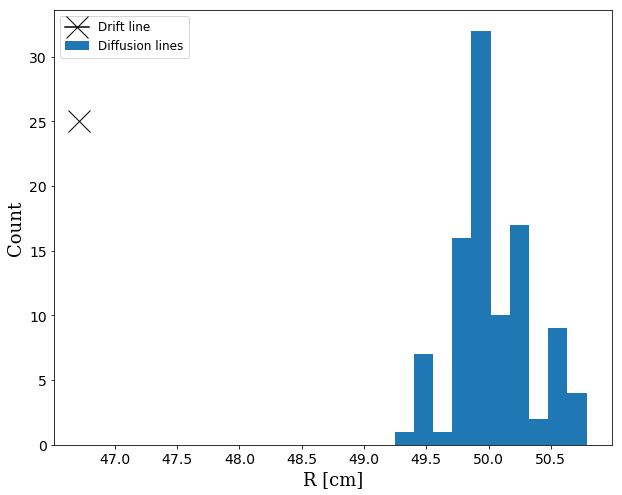

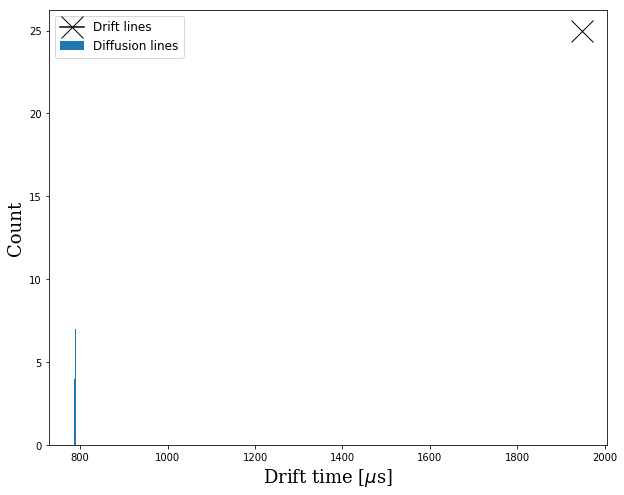

In [99]:
#Get last r entry from each drift line
r_list = []
z_list = []
t_list = []
j=-1
#print j
for f in file_list[:-1]:
    r,z,t= Get_i_line_from_file(f,j)
    r_list.append(r)
    z_list.append(z)
    t_list.append(t)
    
#print r_list

#filename="../SingleDriftLineCalc_.5cm_r30cm_z0.5cm_0504.txt"
r,z,t=Get_i_line_from_file(filename,pop)

figure(1)
plt.hist(r_list,label='Diffusion lines')
plt.plot([r], [25], marker="x", color='k', markersize=22, label='Drift line')

plt.xlabel('R [cm]',fontsize=18,family='serif')
plt.ylabel('Count',fontsize=18,family='serif')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
pylab.legend(loc='best', fontsize=12)

figure(3)
plt.hist(t_list,  label='Diffusion lines')
plt.plot([t], [25], marker="x", color='black', markersize=22, label='Drift lines')
plt.xlabel('Drift time [$\mu$s]',fontsize=18,family='serif')
plt.ylabel('Count',fontsize=18,family='serif')
pylab.legend(loc='best', fontsize=12)

print "Final R and DT for diffusion and drift lines"


99


Text(0,0.5,'Count')

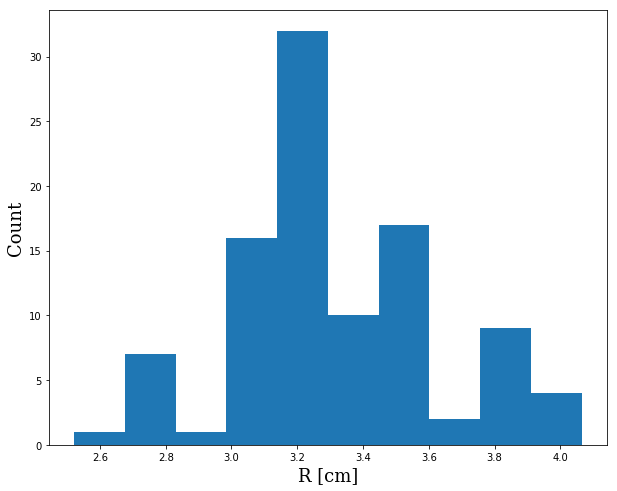

In [95]:
#Zero Arrays
from scipy.stats import norm

zeroed_r_array = np.asarray(r_list)-r
print len(zeroed_r_array)




fit_mu, fit_sigma = norm.fit(zeroed_r_array)

GausFit_x = np.arange(-.8, .8, .01)
GausFit_y = vGaussian(GausFit_x, fit_mu, fit_sigma)

GausPred_x = np.arange(-.8, .8, .01)
GausPred_y = vGaussian(GausFit_x, 0, pow(2*D_T*t,.5))






figure(1)
plt.hist(zeroed_r_array,label='Diffusion lines')
#plt.plot([r], [25], marker="x", color='k', markersize=22, label='Drift line')

plt.xlabel('R [cm]',fontsize=18,family='serif')
plt.ylabel('Count',fontsize=18,family='serif')


(11,)
[2.5221  2.67634 2.83058 2.98482 3.13906 3.2933  3.44754 3.60178 3.75602
 3.91026 4.0645 ]
(10,)
[ 1.  7.  1. 16. 32. 10. 17.  2.  9.  4.]



	count = 0 / 10
bin_mids	 bin_count
2.5992199999999945	1.0
2.753459999999995	7.0
2.907699999999995	1.0
3.0619399999999946	16.0
3.216179999999995	32.0
3.370419999999995	10.0
3.5246599999999955	17.0
3.678899999999995	2.0
3.8331399999999953	9.0
3.9873799999999955	4.0

-------
NEW BINS
bin_mids	 bin_count
2.5992199999999945	1.0
2.753459999999995	7.0
2.907699999999995	1.0
3.0619399999999946	16.0
3.216179999999995	32.0
3.370419999999995	10.0
3.5246599999999955	17.0
3.678899999999995	2.0
3.8331399999999953	9.0
3.9873799999999955	4.0


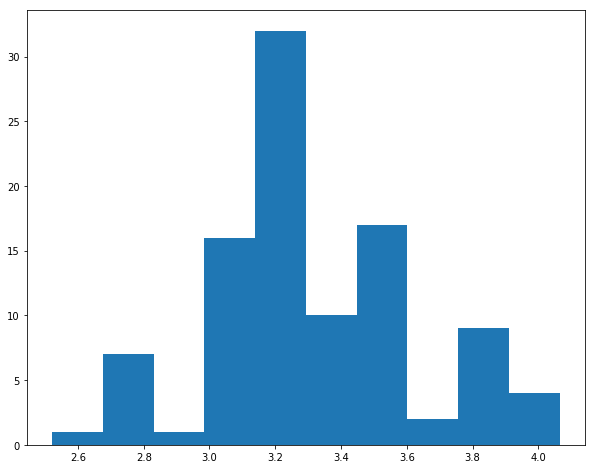

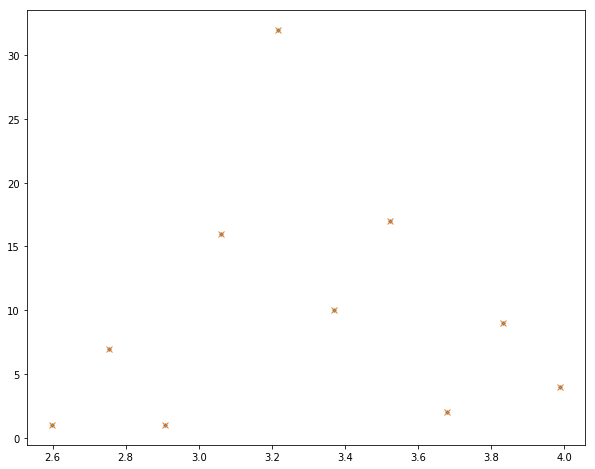

In [96]:
#Inspect initial histogram
num_bins =  10
#(full_n, full_bins, full_patches) = plt.hist(Full_Reduced_R_list, bins=num_bins)
figure(1)
(n_R, bins, patches) = plt.hist(zeroed_r_array, bins=num_bins)

#Get bin mids
print bins.shape
print bins

R_bin_mids_list = []
for i in range(1, len(bins)):
    R_bin_mids_list.append( (bins[i] + bins[i-1])/2 )
    
this_half_bid_width = .5*(R_bin_mids_list[1] - R_bin_mids_list[0])

#print bin_mids_list[-1]
#print bin_mids_list[-1]+this_half_bid_width
#print bin_mids_list[-1]-this_half_bid_width


#Remove bins with n<threshold, & remove top bin
threshold=0
print n_R.shape
print n_R
print "\n"

counter = 0
new_bin_mids_list = []
new_n_list = []
for i in range(0, len(n_R)):
    if n_R[i] < threshold:# or n_R[i] > 15000:
        #print( str(i)+": ("+str(bin_mids_list[i])+", "+str(n[i])+")" )
        counter +=1
    else:
        new_bin_mids_list.append(R_bin_mids_list[i])
        new_n_list.append(n_R[i])

#new_bin_mids_list = new_bin_mids_list[:-1]
#new_n_list =new_n_list[:-1]

#new_bin_mids_list = new_bin_mids_list[:-1]
#new_n_list =new_n_list[:-1]

#new_bin_mids_list = new_bin_mids_list[:-1]
#new_n_list =new_n_list[:-1]

#new_bin_mids_list = new_bin_mids_list[:-1]
#new_n_list =new_n_list[:-1]

#new_bin_mids_list = new_bin_mids_list[:-1]
#new_n_list =new_n_list[:-1]

print("\n\tcount = "+str(counter)+" / "+str(len(n_R)))


#Inspect bins
print "bin_mids\t bin_count"
for i in range(0,len(R_bin_mids_list)):
    print str(R_bin_mids_list[i])+"\t"+str(n_R[i])
    


#Inspect bins
print "\n-------\nNEW BINS"
print "bin_mids\t bin_count"
for i in range(0,len(new_bin_mids_list)):
    print str(new_bin_mids_list[i])+"\t"+str(new_n_list[i])

#Inspect elements with n>10
figure(2)
plt.plot(R_bin_mids_list, n_R, ".")
plt.plot(new_bin_mids_list,  new_n_list, 'x')

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35]),
 <a list of 8 Text yticklabel objects>)

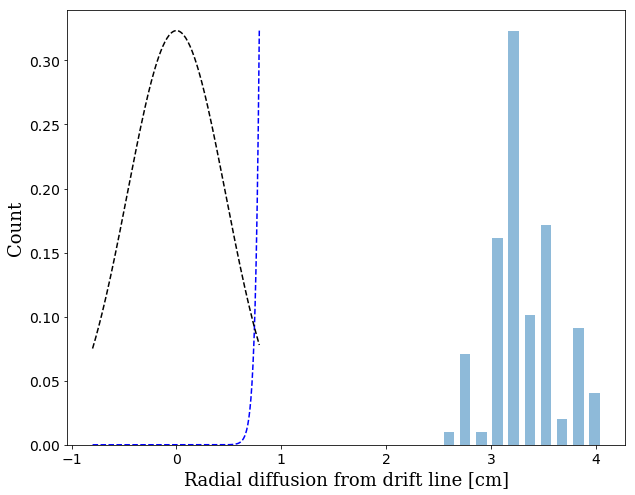

In [97]:
#Final histogram
#num_bins=100
fig = plt.figure(1)
ax = fig.add_subplot(1, 1, 1)

y= new_n_list/sum(new_n_list)

GausFitNorm = max(y)/max(GausFit_y)
GausPredNorm = max(y)/max(GausPred_y)

ax.bar(new_bin_mids_list, y, width=1/float(num_bins), alpha=0.5)
#ax.plot(R_bin_mids_list, n_R, ".b", markersize='10')
#ax.errorbar(R_bin_mids_list, np.asarray(n_R), pow(np.asarray(n_R),.5), ecolor='blue', capsize=3, fmt=' ')
plt.plot(GausFit_x, GausFit_y*GausFitNorm, '--b')
plt.plot(GausPred_x, GausPred_y*GausPredNorm, '--k')

#pylab.legend(loc='best', fontsize=12)
#ax.set_yscale('log')
#plt.xlim(0.85, 1.15)

plt.xlabel('Radial diffusion from drift line [cm]',fontsize=18,family='serif')
plt.ylabel('Count',fontsize=18,family='serif')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)